<a href="https://colab.research.google.com/github/Gelsa45/AI_Driven_Personality_Prediction_and_Job_Recommendation/blob/main/personality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, recall_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout

from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [ ]:
# read data
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Training_Essay_Data.csv')
print(df.shape)
df.head()


(29145, 2)


,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Filter texts with word counts between 170 and 500 for an even distribution and helps model for better generalization
filtered_by_word_count_df = df[df['text'].apply(lambda x: 170 <= len(x.split()) <= 500)]

# print the shape of the filtered DataFrame
print(f"Filtered DataFrame shape: {filtered_by_word_count_df.shape}")

Filtered DataFrame shape: (21118, 2)


In [ ]:
# Filter the texts based on their length by removing the texts with character lenght below 900 and above 3000 which is good for having an evenly distributed data
filtered_data = filtered_by_word_count_df[(filtered_by_word_count_df['text'].apply(len) >= 900) & (filtered_by_word_count_df['text'].apply(len) <= 3000)]

# number of texts remaining after filtering
print(f"Number of texts remaining after filtering: {len(filtered_data)}")

# Plotting the distribution of filtered text lengths
filtered_text_lengths = filtered_data['text'].apply(len)
text_lengths = [len(text.split()) for text in filtered_data['text']]


df = filtered_data


NameError: name 'filtered_by_word_count_df' is not defined

In [ ]:
# Remove the data samples randomly from Human texts to balance the data

generated_count = df['generated'].sum()

human_indices = df[df['generated'] == 0].index
generated_indices = df[df['generated'] == 1].index

# Convert human indices to a pandas Series and sample the same number as generated
human_sampled_indices = pd.Series(human_indices).sample(n=generated_count, random_state=42)

# Create a new balanced dataframe
balanced_df = pd.concat([df.loc[generated_indices], df.loc[human_sampled_indices]])

# Shuffle the dataframe to mix both samples
balanced_df = shuffle(balanced_df, random_state=42)

# print the new distribution
print('Balanced dataset distribution:')
print(balanced_df['generated'].value_counts())

# reset the index
balanced_df = balanced_df.reset_index(drop=True)

Balanced dataset distribution:
generated
0    8774
1    8774
Name: count, dtype: int64


In [ ]:
# get all words
text = balanced_df.text.values
words = ' '.join(text)
words = words.split()

# build vocabulary
vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)
ID2W = dict(enumerate(vocab, 1))
ID2W[0] = '<PAD>' # special word for paddding purpose, and the index is 0
vectorizer = {word: ID for ID, word in ID2W.items()}

import pickle

# Save the tokenizer (vectorizer)
with open('/content/drive/MyDrive/ai_text_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)



# text vectorization and padding
vecs = [[vectorizer[w] for w in r.split()] for r in tqdm(text)]

# Seq length = 340 which is little more than median and more than average word count
seq_length = 340

X = np.full((len(vecs), seq_length), 0, dtype=int)
for i, vec in enumerate(vecs):
    X[i, :len(vec)] = np.array(vec)[:seq_length]

print('Text vectors:', X.shape)
Y = balanced_df.generated.to_numpy()
print('Labels:', Y.shape)


100%|██████████| 17548/17548 [00:01<00:00, 15121.22it/s]


Text vectors: (17548, 340)
Labels: (17548,)


In [ ]:
# Split data into train (70%), validation (15%), and test (15%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Train set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)
print("Test set:", X_test.shape, Y_test.shape)

batch_size = 128
train_data = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(Y_train, dtype=torch.float)), batch_size=batch_size, shuffle=True)
val_data = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(Y_val, dtype=torch.float)), batch_size=batch_size)
test_data = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(Y_test, dtype=torch.float)), batch_size=batch_size)

Train set: (12283, 340) (12283,)
Validation set: (2632, 340) (2632,)
Test set: (2633, 340) (2633,)


In [ ]:
vocab_size = len(vectorizer)  # Number of unique words in your vocabulary
embedding_dim = 340
seq_length = 340  # Max sequence length
num_classes = 1

inputs = Input(shape=(seq_length,))

embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length)(inputs)
cnn = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(embedding)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=4)(cnn)
cnn = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
lstm = LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(cnn)
lstm = LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dropout(0.5)(dense)
dense = Dense(128, activation='relu')(dense)
dense = Dropout(0.5)(dense)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(num_classes, activation='sigmoid')(dense)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train the model
history = model.fit(train_data, epochs=10, batch_size=batch_size, validation_data=val_data, verbose=1)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 344ms/step - accuracy: 0.7529 - loss: 0.4308 - val_accuracy: 0.9468 - val_loss: 0.4643
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 345ms/step - accuracy: 0.9946 - loss: 0.0222 - val_accuracy: 0.9027 - val_loss: 0.3293
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 325ms/step - accuracy: 0.9983 - loss: 0.0064 - val_accuracy: 0.8484 - val_loss: 0.4138
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 322ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 0.9574 - val_loss: 0.1256
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 340ms/step - accuracy: 0.9980 - loss: 0.0103 - val_accuracy: 0.9897 - val_loss: 0.0377
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 323ms/step - accuracy: 0.9991 - loss: 0.0039 - val_accuracy: 0.9939 - val_loss: 0.0331
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - accuracy: 0.9995 - loss: 0.0013 - val_accuracy: 0.9966 - val_loss: 0.0213
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 326ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accu

In [ ]:
# Save the trained model
model.save("/content/ai_text_detection_model.h5")

print("Model training complete and saved successfully!")

Model training complete and saved successfully!


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9947 - loss: 0.0351
Test Accuracy: 99.28%


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 337ms/step - accuracy: 1.0000 - loss: 9.8532e-05 - val_accuracy: 0.9829 - val_loss: 0.1403
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - accuracy: 0.9986 - loss: 0.0038 - val_accuracy: 0.9928 - val_loss: 0.0199
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 405ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy: 0.9837 - val_loss: 0.0672
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9928 - val_loss: 0.0307
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9943 - val_loss: 0.0355
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 354ms/step - accuracy: 0.9999 - loss: 5.6417e-04 - val_accuracy: 0.9954 - val_loss: 0.0227
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 328ms/step - accuracy: 1.0000 - loss: 8.4866e-05 - val_accuracy: 0.9951 - val_loss: 0.0324
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 323ms/step - accuracy: 0.9998 - loss: 3.878

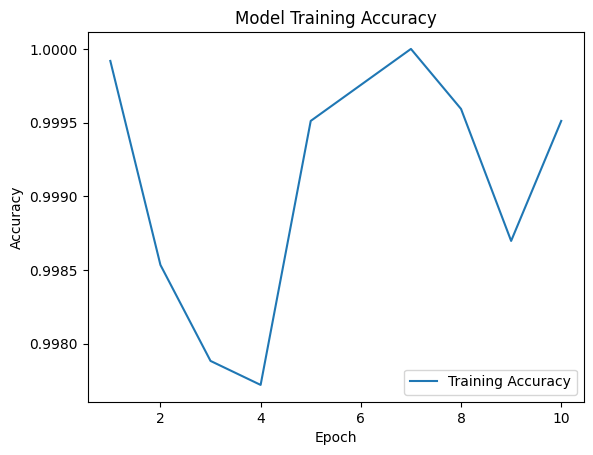

In [ ]:
import matplotlib.pyplot as plt

# Train the model (Make sure this cell is executed before plotting)
history = model.fit(train_data, epochs=10, batch_size=batch_size, validation_data=val_data, verbose=1)

# Extract training accuracy from the history object
training_accuracy = history.history['accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(training_accuracy) + 1)

# Plot the training accuracy
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
cs5814_mbti_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mbti.csv')
cs5814_mbti_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8726 entries, 0 to 8725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8726 non-null   object
 1   posts   8726 non-null   object
dtypes: object(2)
memory usage: 136.5+ KB


<ipython-input-17-12ff7139132c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


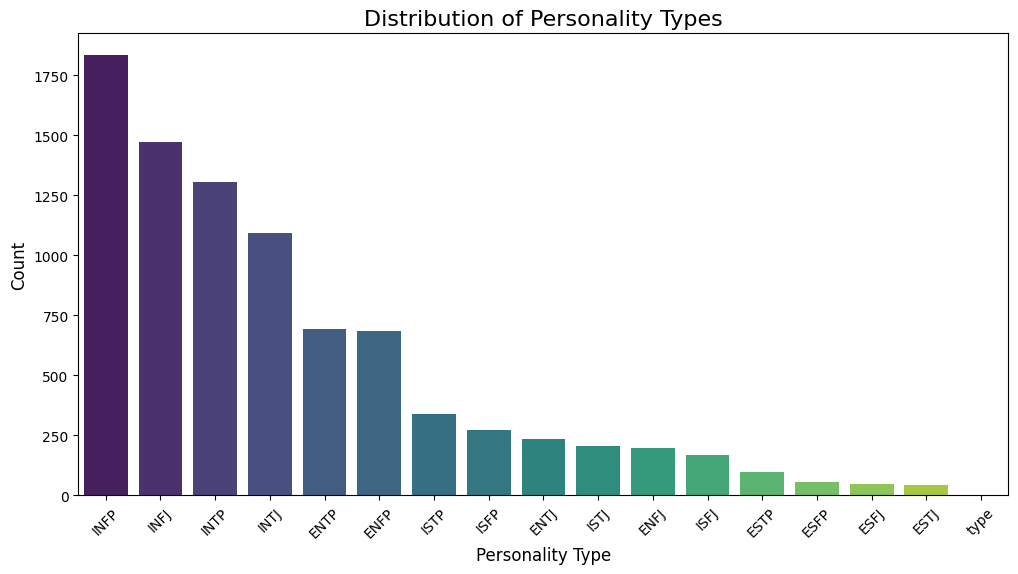

Class Distribution:
 type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     691
ENFP     684
ISTP     337
ISFP     271
ENTJ     236
ISTJ     205
ENFJ     196
ISFJ     166
ESTP      96
ESFP      55
ESFJ      48
ESTJ      43
type       1
Name: count, dtype: int64


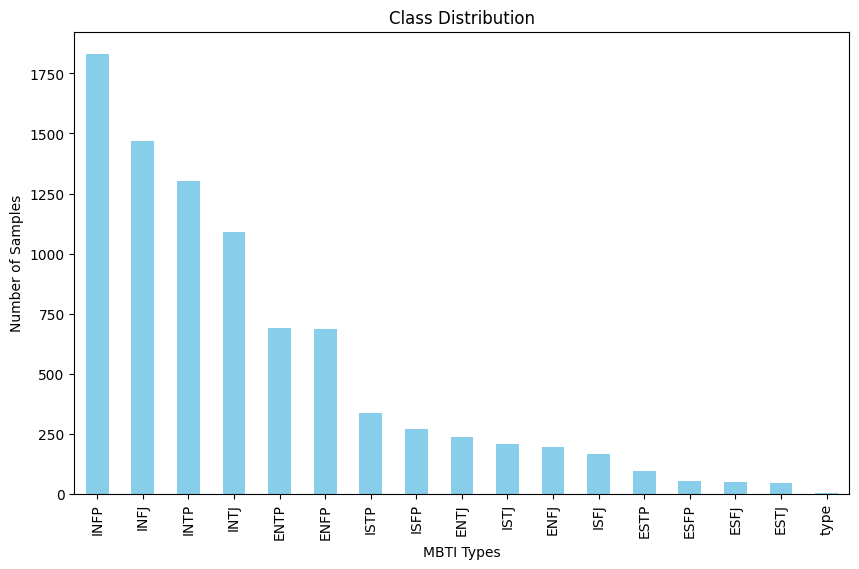

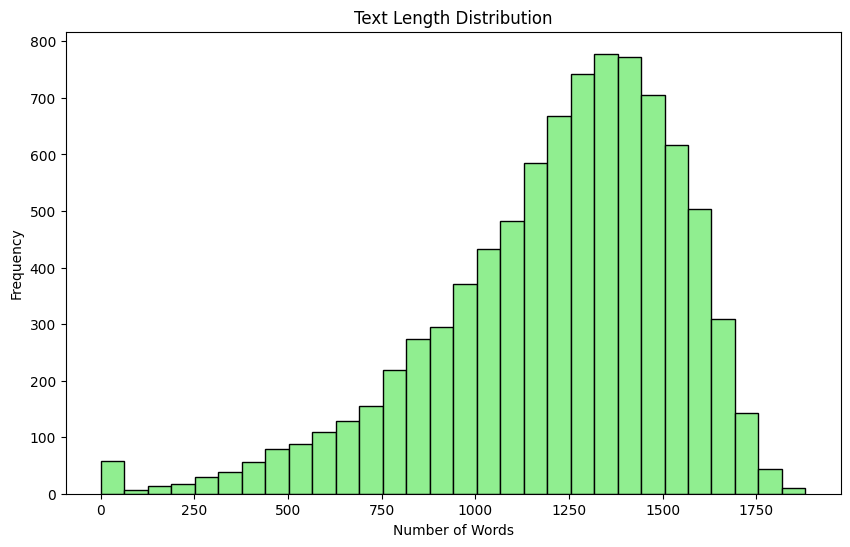

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.countplot(
    x='type',
    data=cs5814_mbti_df,
    order=cs5814_mbti_df['type'].value_counts().index,
    palette='viridis'
)
plt.title("Distribution of Personality Types", fontsize=16)
plt.xlabel("Personality Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

cs5814_mbti_df = cs5814_mbti_df.dropna()

cs5814_class_distribution = cs5814_mbti_df['type'].value_counts()
print("Class Distribution:\n", cs5814_class_distribution)

plt.figure(figsize=(10, 6))
cs5814_class_distribution.plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("MBTI Types")
plt.ylabel("Number of Samples")
plt.show()

cs5814_text_lengths = cs5814_mbti_df['posts'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
plt.hist(cs5814_text_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

#### Balancing the dataset

Balanced Class Distribution:
 type
INFJ    1832
ENTP    1832
INTP    1832
INTJ    1832
ENTJ    1832
ENFJ    1832
INFP    1832
ENFP    1832
ISFP    1832
ISTP    1832
ISFJ    1832
ISTJ    1832
ESTP    1832
ESFP    1832
ESTJ    1832
ESFJ    1832
type    1832
Name: count, dtype: int64


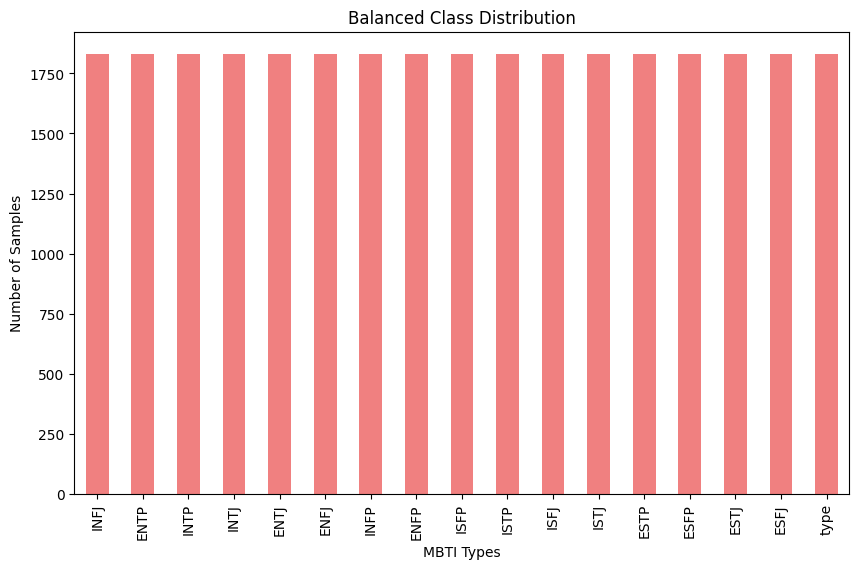

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler # Import the correct class
cs5814_texts = cs5814_mbti_df['posts']
cs5814_labels = cs5814_mbti_df['type']

cs5814_unique_labels = sorted(cs5814_labels.unique())
cs5814_label_to_idx = {label: idx for idx, label in enumerate(cs5814_unique_labels)}
cs5814_idx_to_label = {idx: label for label, idx in cs5814_label_to_idx.items()}
cs5814_encoded_labels = np.array([cs5814_label_to_idx[label] for label in cs5814_labels])

cs5814_ros = RandomOverSampler(random_state=42)
cs5814_X_resampled, cs5814_y_resampled = cs5814_ros.fit_resample(cs5814_texts.values.reshape(-1, 1), cs5814_encoded_labels)

cs5814_balanced_df = pd.DataFrame({
    'posts': cs5814_X_resampled.flatten(),
    'type': [cs5814_idx_to_label[label] for label in cs5814_y_resampled]
})

cs5814_balanced_class_distribution = cs5814_balanced_df['type'].value_counts()
print("Balanced Class Distribution:\n", cs5814_balanced_class_distribution)

plt.figure(figsize=(10, 6))
cs5814_balanced_class_distribution.plot(kind='bar', color='lightcoral')
plt.title("Balanced Class Distribution")
plt.xlabel("MBTI Types")
plt.ylabel("Number of Samples")
plt.show()

cs5814_balanced_df.to_csv('balanced_mbti_data.csv', index=False)

### LSTM

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

cs5814_df = pd.read_csv('/content/balanced_mbti_data.csv')

cs5814_label_encoder = LabelEncoder()
cs5814_df['encoded_type'] = cs5814_label_encoder.fit_transform(cs5814_df['type'])

cs5814_train_texts, cs5814_test_texts, cs5814_y_train, cs5814_y_test = train_test_split(
    cs5814_df['posts'].values,  # Text data
    cs5814_df['encoded_type'].values,  # Encoded labels
    test_size=0.2,
    random_state=42
)

In [ ]:
import pickle
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open('cs5814_label_encoder.pkl', 'wb') as f:
    pickle.dump(cs5814_label_encoder, f)

cs5814_max_words = 20000
cs5814_max_len = 128

cs5814_tokenizer = Tokenizer(num_words=cs5814_max_words, oov_token="<OOV>")
cs5814_tokenizer.fit_on_texts(cs5814_train_texts)

cs5814_train_sequences = cs5814_tokenizer.texts_to_sequences(cs5814_train_texts)
cs5814_test_sequences = cs5814_tokenizer.texts_to_sequences(cs5814_test_texts)

cs5814_X_train_padded = pad_sequences(cs5814_train_sequences, maxlen=cs5814_max_len, padding='post')
cs5814_X_test_padded = pad_sequences(cs5814_test_sequences, maxlen=cs5814_max_len, padding='post')

with open('cs5814_tokenizer.pkl', 'wb') as f:
    pickle.dump(cs5814_tokenizer, f)
np.save('cs5814_X_train_padded.npy', cs5814_X_train_padded)
np.save('cs5814_X_test_padded.npy', cs5814_X_test_padded)
np.save('cs5814_y_train.npy', cs5814_y_train)
np.save('cs5814_y_test.npy', cs5814_y_test)

print("CS5814 Dataset loaded, tokenized, and saved!")

CS5814 Dataset loaded, tokenized, and saved!


In [ ]:
import pickle
import numpy as np
cs5814_max_words = 20000

with open('cs5814_tokenizer.pkl', 'rb') as f:
    cs5814_tokenizer = pickle.load(f)
cs5814_X_train_padded = np.load('cs5814_X_train_padded.npy')
cs5814_X_test_padded = np.load('cs5814_X_test_padded.npy')
cs5814_y_train = np.load('cs5814_y_train.npy')
cs5814_y_test = np.load('cs5814_y_test.npy')

cs5814_embedding_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        cs5814_values = line.split()
        cs5814_word = cs5814_values[0]
        cs5814_coefs = np.asarray(cs5814_values[1:], dtype='float32')
        cs5814_embedding_index[cs5814_word] = cs5814_coefs

cs5814_embedding_dim = 100
cs5814_embedding_matrix = np.zeros((cs5814_max_words, cs5814_embedding_dim))
for cs5814_word, cs5814_i in cs5814_tokenizer.word_index.items():
    if cs5814_i < cs5814_max_words:
        cs5814_embedding_vector = cs5814_embedding_index.get(cs5814_word)
        if cs5814_embedding_vector is not None:
            cs5814_embedding_matrix[cs5814_i] = cs5814_embedding_vector

print("CS5814 Preprocessed data and embeddings loaded successfully!")

CS5814 Preprocessed data and embeddings loaded successfully!


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-04-03 14:23:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-03 14:23:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-03 14:23:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


cs5814_lstm_model = Sequential([
    Embedding(input_dim=cs5814_max_words, output_dim=cs5814_embedding_dim, weights=[cs5814_embedding_matrix], input_length=cs5814_max_len, trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(cs5814_y_train)), activation='softmax')
])

cs5814_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cs5814_early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

cs5814_history = cs5814_lstm_model.fit(
    cs5814_X_train_padded, cs5814_y_train,
    validation_data=(cs5814_X_test_padded, cs5814_y_test),
    epochs=10,
    batch_size=32,
    callbacks=[cs5814_early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1262 - loss: 2.6985 - val_accuracy: 0.2366 - val_loss: 2.4067
Epoch 2/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2585 - loss: 2.3039 - val_accuracy: 0.3145 - val_loss: 2.0523
Epoch 3/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3360 - loss: 1.9962 - val_accuracy: 0.4060 - val_loss: 1.7962
Epoch 4/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.4174 - loss: 1.7799 - val_accuracy: 0.4860 - val_loss: 1.5810
Epoch 5/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5002 - loss: 1.5308 - val_accuracy: 0.5752 - val_loss: 1.3017
Epoch 6/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5702 - loss: 1.3104 - val_accuracy: 0.6211 - val_loss: 1.1434
Epoch 7/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6267 - loss: 1.1162 - val_accuracy: 0.6630 - val_loss: 0.9943
Epoch 8/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6586 - loss: 0.9992 - val_accuracy: 0.67

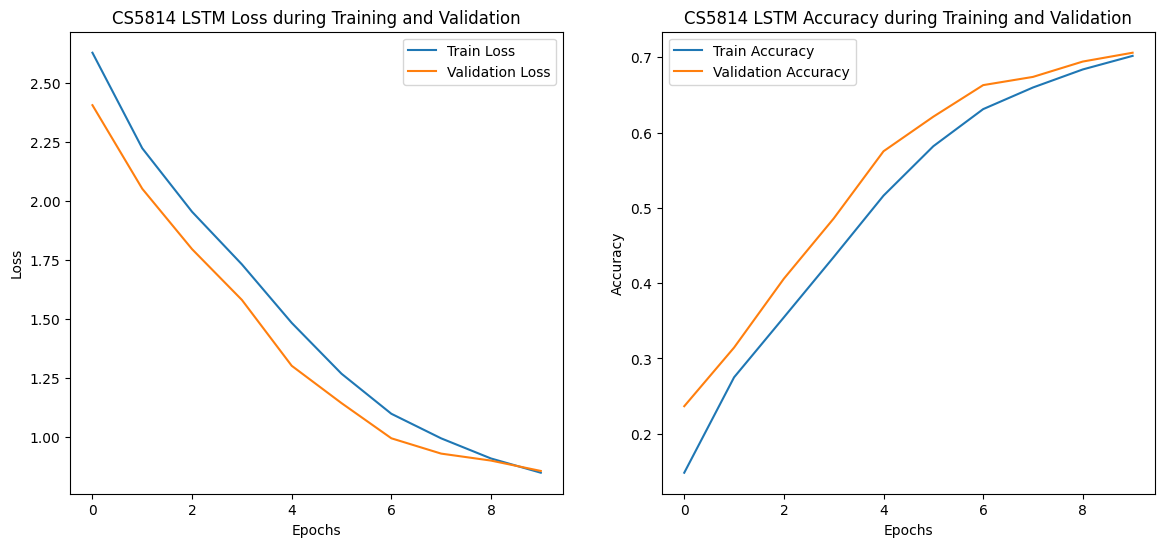

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

CS5814 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       387
           1       0.38      0.60      0.46       378
           2       0.82      0.95      0.88       390
           3       0.38      0.52      0.44       358
           4       0.97      0.87      0.92       369
           5       0.99      0.86      0.92       356
           6       0.97      0.91      0.94       368
           7       0.94      0.92      0.93       359
           8       0.28      0.04      0.07       372
           9       0.16      0.09      0.12       353
          10       0.32      0.29      0.30       373
          11       0.35      0.04      0.08       345
          12       0.95      1.00      0.98       372
          13       0.75      0.97      0.85       358
          14       0.89      0.99      0.94       363
          15       0.72      0.91      0.80       364
         

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report

# Define and fit the label encoder
cs5814_label_encoder = LabelEncoder()
cs5814_y_train_encoded = cs5814_label_encoder.fit_transform(cs5814_y_train)
cs5814_y_test_encoded = cs5814_label_encoder.transform(cs5814_y_test)  # Transform test labels

# Plot Loss and Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cs5814_history.history['loss'], label='Train Loss')
plt.plot(cs5814_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CS5814 LSTM Loss during Training and Validation')

plt.subplot(1, 2, 2)
plt.plot(cs5814_history.history['accuracy'], label='Train Accuracy')
plt.plot(cs5814_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CS5814 LSTM Accuracy during Training and Validation')

plt.show()

# Model Predictions
cs5814_y_pred = cs5814_lstm_model.predict(cs5814_X_test_padded)
cs5814_y_pred_classes = np.argmax(cs5814_y_pred, axis=1)

# Fixing the TypeError in Classification Report
target_names = [str(c) for c in cs5814_label_encoder.classes_]

print("\nCS5814 Classification Report:")
print(classification_report(cs5814_y_test_encoded, cs5814_y_pred_classes, target_names=target_names))


###Bi-Lstm

Shape of  y_train
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


623/623 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.1574 - loss: 2.5688 - val_accuracy: 0.4570 - val_loss: 1.7025
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4951 - loss: 1.5221 - val_accuracy: 0.6376 - val_loss: 1.0809
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7033 - loss: 0.8485 - val_accuracy: 0.7624 - val_loss: 0.6823
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8081 - loss: 0.5229 - val_accuracy: 0.8061 - val_loss: 0.5774
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8783 - loss: 0.3339 - val_accuracy: 0.8232 - val_loss: 0.5833
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9180 - loss: 0.2272 - val_accuracy: 0.8433 - val_loss: 0.6113
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


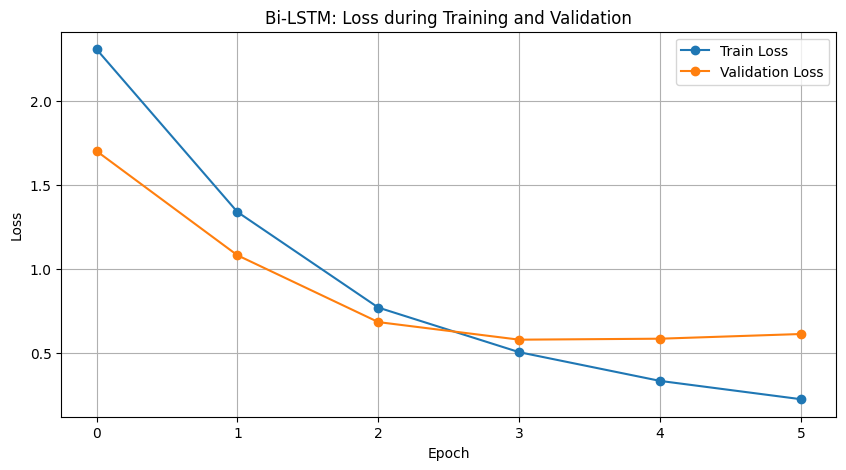

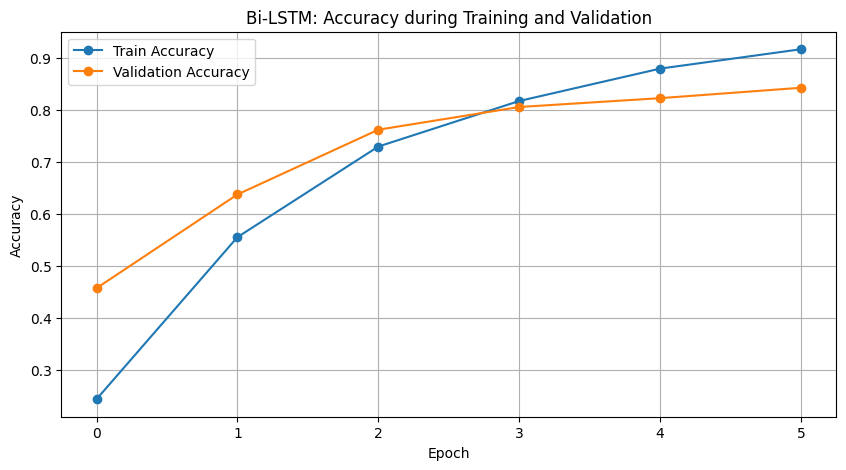

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
cs5814_y_train = np.load('/content/cs5814_y_train.npy')
# Print the shape of y_train
print("Shape of  y_train")

# Convert labels to categorical if they are in integer form
if len(cs5814_y_train.shape) == 1 or cs5814_y_train.ndim == 1:
    cs5814_y_train = to_categorical(cs5814_y_train, num_classes=len(cs5814_label_encoder.classes_))
    cs5814_y_test = to_categorical(cs5814_y_test, num_classes=len(cs5814_label_encoder.classes_))

# Define Bi-LSTM model
cs5814_bilstm_model = Sequential([
    Embedding(input_dim=cs5814_max_words, output_dim=100, weights=[cs5814_embedding_matrix],
              input_length=cs5814_X_train_padded.shape[1], trainable=True),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(cs5814_y_train.shape[1], activation='softmax')
])



# Compile the model
cs5814_bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
cs5814_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Train the model
cs5814_bilstm_history = cs5814_bilstm_model.fit(
    cs5814_X_train_padded, cs5814_y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[cs5814_early_stopping]
)

# Predictions
cs5814_y_pred = cs5814_bilstm_model.predict(cs5814_X_test_padded)
cs5814_y_pred_classes = np.argmax(cs5814_y_pred, axis=1)
cs5814_y_true_classes = np.argmax(cs5814_y_test, axis=1)


# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(cs5814_bilstm_history.history['loss'], marker='o', label='Train Loss')
plt.plot(cs5814_bilstm_history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Bi-LSTM: Loss during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(cs5814_bilstm_history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(cs5814_bilstm_history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Bi-LSTM: Accuracy during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
cs5814_bilstm_model.save("bilstm_model.h5")
import pickle
pickle.dump(cs5814_tokenizer, open("tokenizer.pkl", "wb"))
pickle.dump(cs5814_label_encoder, open("label_encoder.pkl", "wb"))


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import os

# Create the 'models' directory if it doesn't exist
if not os.path.exists("models"):
    os.makedirs("models")

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mbti_career_mapping.csv")

# Group all careers by MBTI type
df_grouped = df.groupby("MBTI Type")["Career Recommendation"].apply(list).reset_index()

# Encode MBTI personality types
mbti_encoder = LabelEncoder()
df_grouped["mbti_encoded"] = mbti_encoder.fit_transform(df_grouped["MBTI Type"])

# Multi-label binarizer for career recommendations
career_mlb = MultiLabelBinarizer()
y = career_mlb.fit_transform(df_grouped["Career Recommendation"])

# Define features (X) – only MBTI encoding is needed
X = df_grouped[["mbti_encoded"]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Save the model and encoders
pickle.dump(rf_model, open("models/mbti_career_model.pkl", "wb"))
pickle.dump(mbti_encoder, open("models/mbti_label_encoder.pkl", "wb"))
pickle.dump(career_mlb, open("models/career_mlb.pkl", "wb"))

print("Career recommendation model trained and saved.")


Career recommendation model trained and saved.


In [ ]:
import pickle
import pandas as pd

# Load the trained model and encoders
rf_model = pickle.load(open("models/mbti_career_model.pkl", "rb"))
mbti_encoder = pickle.load(open("models/mbti_label_encoder.pkl", "rb"))
career_mlb = pickle.load(open("models/career_mlb.pkl", "rb"))

# Sample MBTI type (Change this to test other types)
sample_mbti = "INTJ"

# Encode the MBTI type
sample_mbti_encoded = mbti_encoder.transform([sample_mbti])[0]

# Convert to DataFrame
sample_df = pd.DataFrame({"mbti_encoded": [sample_mbti_encoded]})

# Make Prediction
predicted_career_binary = rf_model.predict(sample_df)

# Convert binary prediction back to career labels
predicted_careers = career_mlb.inverse_transform(predicted_career_binary)
print(f"Predicted careers for {sample_mbti}: {', '.join(predicted_careers[0])}")


Predicted careers for INTJ: Engineer, IT Manager, Researcher, Scientist, Strategist
